# Setup

In this section, we will make sure the hardware and software environment has been configured properly.

Check for a GPU. Google Colab will assign you either a T4 (newer) or K80 (older) GPU.

You might see an error: `
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running. `

If you see the above error, please go to **Runtime > Change runtime type > Hardware accelerator** and select **GPU**.

In [1]:
!nvidia-smi

Sun Jul 28 16:23:48 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

TensorFlow 2.0 is still in beta, hence we will need to install it manually.

Colab currently ships with TensorFlow 1.14 as of 17 July 2019.

In [2]:
!pip install tensorflow-gpu==2.0b1

     |████████████████████████████████| 348.9MB 65kB/s 
     |████████████████████████████████| 3.1MB 39.6MB/s 
     |████████████████████████████████| 501kB 41.1MB/s 


In [3]:
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.0.0-beta1


# Classifying Handwritten Digits (MNIST)

In this introductory lab, we will be using `tf.keras` to create a simple model to classify handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). This is a very classic problem, and is often used as the "Hello World" tutorial in deep learning. It consists of 60,000 handwritten digits, and the task is to recognise these digits as 0 to 9.

## Loading the MNIST dataset

Luckily for us, the mechanism to load MNIST is already built into `tf.keras`, which makes life really easy for us. For most real world datasets, we will not be so lucky. However, for certain widely use research datasets, you should be able to find them in `tf.keras.datasets` or in [TensorFlow Datasets](https://www.tensorflow.org/datasets). 

In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# dataset parameters
num_classes = 10
width, height = 28, 28

11493376/11490434 [==============================] - 0s 0us/step


Let's take a look at the data:

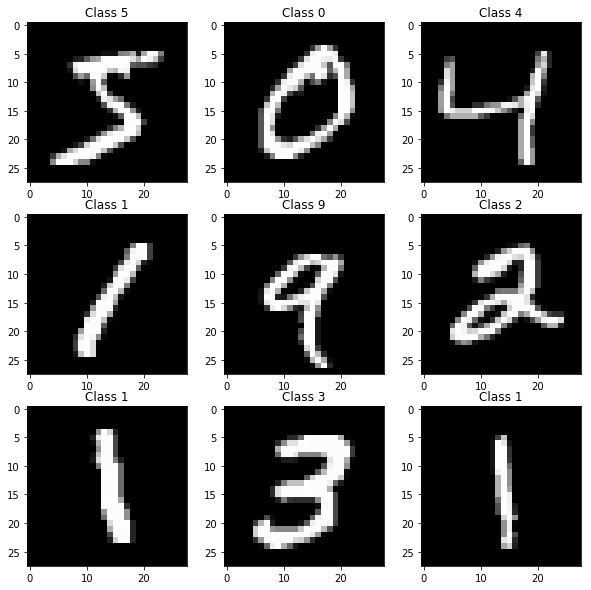

In [5]:
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))
    
plt.show()

Typically, we need to preprocess the data in some way.

Here, we want to format our data into a standard `NWHC` format, also known as the "channels last" format for images.

This is the most commonly used format for images in deep learning:

```python
[number, width, height, channels]
```

* `number`: `N`, the number of images
* `width`: `W`, the width (rows) of an image
* `height`: `H`, the height (columns) of an image
* `channels`: `C`, the number of colour channels (e.g. 3 for RGB, 1 for grayscale)



In [0]:
# reshape to [number, width, height, channels]

x_train = x_train.reshape(x_train.shape[0], width, height, 1)
x_test = x_test.reshape(x_test.shape[0], width, height, 1)
input_shape = (width, height, 1)

Next, we want to make sure the data we load is of the correct type ("float32", aka FP32, or 32-bit floating point numbers).

We also want to normalise the data. Here, we are dividing all the numbers by 255 

In [0]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

In [8]:
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Next, we need to convert the labels in the dataset from a vector of numbers (`0` to `9`) to one-hot (categorical) vectors.

Here's what the class label looks like:

In [9]:
print("Class label:", y_train[0])

Class label: 5


In [0]:
# convert class label to one-hot (categorical) class vectors

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [11]:
print("One-hot vector:", y_train[0])

One-hot vector: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## Building a Model

We will now be building a simple model in `tf.keras` using the [Sequential API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Sequential).

There is also the [Functional API](https://www.tensorflow.org/beta/guide/keras/functional) or the [Model Subclassing](https://keras.io/models/about-keras-models/#model-subclassing) design pattern which gives you more flexibility. 

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(width, height, 1)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

Congratulations, you have built the model. Now, we need to compile the model into a static graph for training. We can do that using `model.compile`, and in doing so have to pass a few arguments:

* `optimizer`: the type of gradient descend algorithm to use
* `loss`: the type of metric used to describe the error of the model to the `optimizer`
* `metric`: any additional metric to display during training


In [0]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## Visualising a Model

It is good to visualise a model as a form of sanity check to see if you built it correctly. You'd want to check the dimensions, input/outputs, as well as number of parameters.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


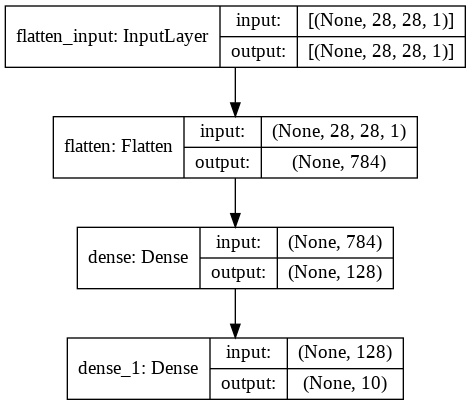

In [15]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB"
)

## Training a Model

In [16]:
model.fit(x_train, y_train,
          batch_size=64,
          epochs=10)

W0728 16:24:45.096920 140520025991040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.2989 - accuracy: 0.9153
Epoch 2/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.1346 - accuracy: 0.9611
Epoch 3/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0934 - accuracy: 0.9733
Epoch 4/10
60000/60000 [==============================] - 3s 55us/sample - loss: 0.0712 - accuracy: 0.9794
Epoch 5/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0563 - accuracy: 0.9836
Epoch 6/10
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0451 - accuracy: 0.9862
Epoch 7/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0365 - accuracy: 0.9897
Epoch 8/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0302 - accuracy: 0.9914
Epoch 9/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.0246 - accuracy: 0.9931
Epoch 10/10
60

## Testing a Model

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.06988833947443636
Test accuracy: 0.9788
